In [127]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import signal
%matplotlib inline 

## Check sides (of hand)

In [ ]:
pd.read_hdf('//FS2.smpp.local\\RTO\\CIS-PD MUSC\\decoded_forms\\form501.h5')

# Load Data

## Load Watch data

In [ ]:
watchfile = '//FS2.smpp.local\\RTO\\CIS-PD Study\\MJFF Curation\\TaskAcc\\1004_1_Wlkg.csv'

In [2]:
# 1004, trial 1, walking
Watch = pd.read_csv(watchfile)

# convert timestamp to datetime type
Watch['timestamp'] = pd.to_datetime(Watch['timestamp'])

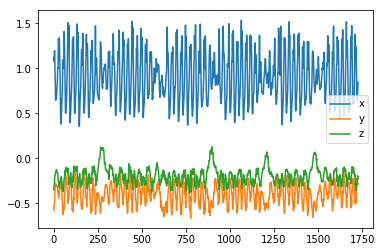

In [53]:
Watch.loc[:,['x','y','z']].plot()

## Load MC10 Sensor data

In [100]:
# Load Right hand accelerometer for subject 1004
MC10 = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Subjects\\1004\\dorsal_hand_right\\d5la7ybu\\2017-07-07T14-20-44-065Z\\accel.csv')

# convert timestamp from UTC to date time format
MC10.loc[:,'Timestamp (ms)'] = MC10['Timestamp (ms)'].apply(

# Downsampling MC10 to match 50Hz on Watch

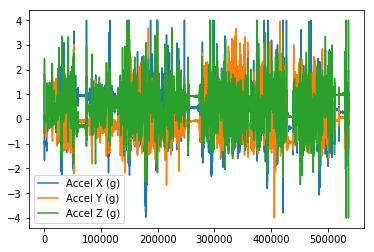

In [71]:
# entire dataset
MC10.plot()

In [105]:
# convert timestamp to datetime type
MC10['Timestamp (ms)'] = pd.to_datetime(MC10['Timestamp (ms)'])

# set Timestamp as index before resampling
MC10 = MC10.set_index('Timestamp (ms)')

pandas.DataFrame.resample
- Notes [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.resample.html)
- defaults: how='mean', axis=0 for index
- args: kind={'timestamp'}, loffset=timedelta

In [114]:
# downsample MC10 from 16 ms interval to 20 ms interval
resampled = MC10.resample('20ms').mean()

In [136]:
## Do I need to change MC10 to resampled?

# reset index so Timestamp is a column
MC10.reset_index(inplace=True)

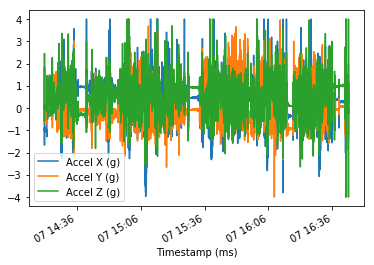

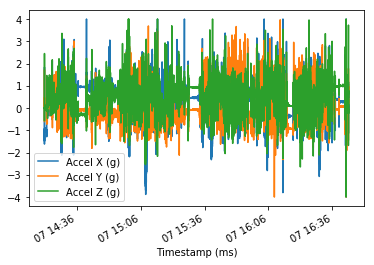

In [119]:
# check plot similarity after resampling
MC10.plot()
resampled.plot()

In [95]:
df = Watch.iloc[:,3:].set_index('timestamp')

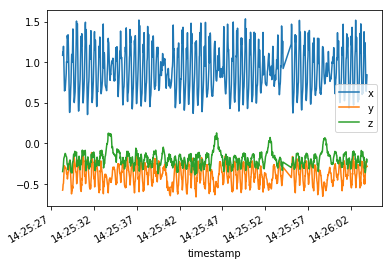

In [97]:
# plot at original 62.5 Hz
df.plot()

## Find matching(?) time range

Done: 
- resample MC10 to match watch frequency (50Hz)
- add buffer (+/- 2s)
- find optimal lag from cross correlation

In [280]:
MC10 = resampled
MC10.reset_index(inplace=True)

In [282]:
# add 2 sec offset for MC10 sensor data
start = Watch.timestamp.min() - timedelta(seconds=2)
stop = Watch.timestamp.max() + timedelta(seconds=2)
inds = (MC10['Timestamp (ms)'] > start) & \
       (MC10['Timestamp (ms)'] < stop)

In [142]:
sum(inds)

2470

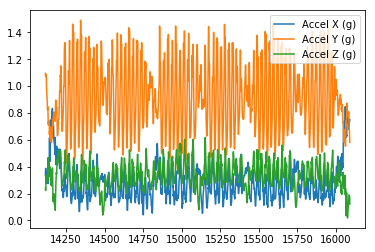

In [283]:
# plot without offset
MC10[inds].iloc[:,1:].plot()

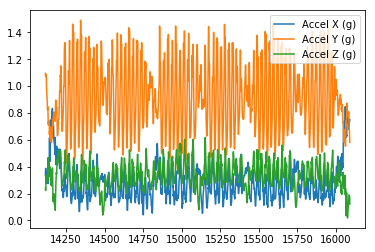

In [284]:
# plot after 2 sec offset
MC10[inds].iloc[:,1:].plot()

# Cross correlation between watch and MC10 sensors

In [11]:
from scipy.signal import correlate, resample

In [16]:
# 
A = resample(MC10['Accel Y (g)'],len(Watch))
B = Watch['x']

C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`,

In [285]:
sensor = MC10[inds].reset_index(drop=True).copy()

In [286]:
sensor.head(5)

,Timestamp (ms),Accel X (g),Accel Y (g),Accel Z (g)
0,2017-07-07 14:25:26.380,0.334051,1.095171,0.240177
1,2017-07-07 14:25:26.400,0.378363,1.073075,0.224308
2,2017-07-07 14:25:26.420,0.387518,1.072709,0.222477
3,2017-07-07 14:25:26.440,0.321599,1.068742,0.275883
4,2017-07-07 14:25:26.460,0.276432,1.087602,0.314641


In [211]:
Watch.iloc[:,3:].head(5)

,timestamp,x,y,z
0,2017-07-07 14:25:28.372,1.084717,-0.577881,-0.348389
1,2017-07-07 14:25:28.392,1.123535,-0.569092,-0.333252
2,2017-07-07 14:25:28.412,1.088135,-0.529053,-0.326660
3,2017-07-07 14:25:28.432,1.083496,-0.506592,-0.301025
4,2017-07-07 14:25:28.452,1.145020,-0.496826,-0.281250


In [202]:
Watch['y'].head(5)

0   -0.577881
1   -0.569092
2   -0.529053
3   -0.506592
4   -0.496826
Name: y, dtype: float64

In [216]:
# use resampled MC10 y-axis to cross correlate against watch x-axis
A = resample(sensor['Accel Y (g)'], len(Watch))#.iloc[:,2]
B = Watch['x']
lag = np.argmax(correlate(A, B))

C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`,

In [217]:
lag

1728

# Plot sensor vs watch data

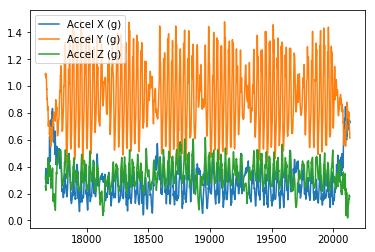

In [171]:
MC10[inds].iloc[:,1:].plot()

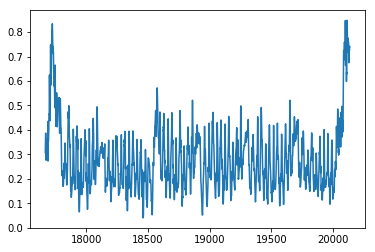

In [214]:
MC10[inds].iloc[:,1].plot()

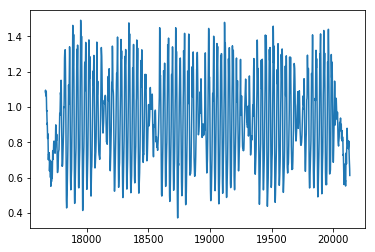

In [173]:
MC10[inds].iloc[:,2].plot()

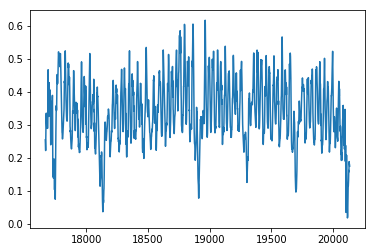

In [174]:
MC10[inds].iloc[:,3].plot()

In [ ]:
MC10.iloc[:,1].plot()

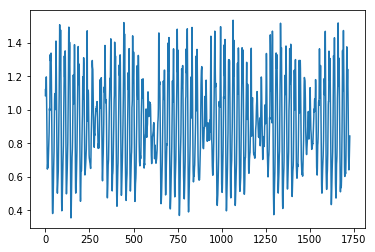

In [215]:
Watch['x'].plot()

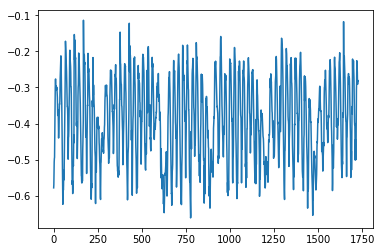

In [169]:
Watch['y'].plot()

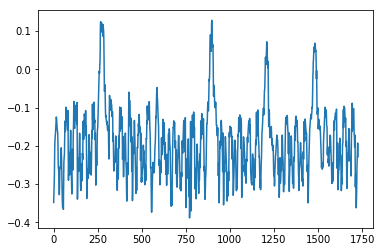

In [170]:
Watch['z'].plot()

# Action list to correlate watch and sensor data
- offset = lag/50

In [218]:
lag

1728

In [219]:
offset = lag/50

In [220]:
offset

34.56

In [ ]:
resample(sensor['Accel Y (g)'], len(Watch))#.iloc[:,2]
B = Watch['x']

In [223]:
len(Watch)

1728

In [227]:
len(resample(sensor['Accel Y (g)'], len(Watch)))

C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`,

1728

In [229]:
len(sensor['Accel Y (g)'])

2470

In [287]:
A = sensor['Accel Y (g)']
B = Watch['x']
lag = np.argmax(correlate(A, B))
offset = lag/50

C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [288]:
print(lag, offset)

1822 36.44


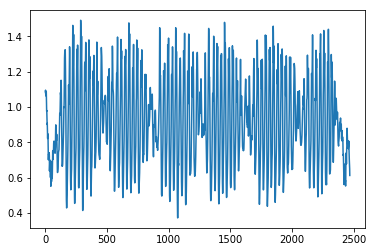

In [234]:
sensor['Accel Y (g)'].plot()

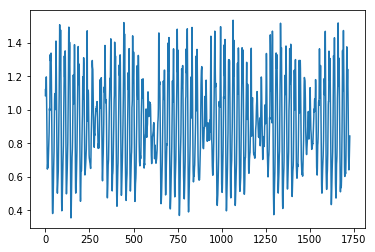

In [235]:
Watch['x'].plot()

C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


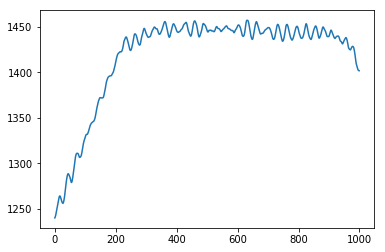

In [246]:
import matplotlib.pyplot
matplotlib.pyplot.plot(correlate(A, B))

In [244]:
len(correlate(A, B))

C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


4197

In [245]:
len(A) + len(B)

4198

In [247]:
corr = correlate(A, B)

C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [255]:
corr[0]

0.9151182126190246

In [254]:
A.values[0]*B.values[-1]

0.9151182126192108

In [260]:
(lag-len(B)+1)/50 - 2

6.08

In [289]:
lag-len(B)

94

In [290]:
A1 = A.copy()

In [292]:
A1.index = A.index-(lag-len(B))

In [299]:
# Calculate time (in sec) that MC10 is behind the Watch
(lag-len(B))/50 - 2

-0.1200000000000001

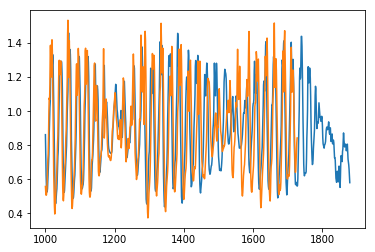

In [296]:
ax = A1.loc[1000:].plot()
B.loc[1000:].plot(ax = ax)